**ACKNOWLEDGEMENT**: The original dataset <data.tsv> and general guideline was provided by Professor Jonathan Rose in the NLP class he taught in 2024.

# Data Preparation

The data preparation steps are pretty much the same as what we have done when building the baseline model.

To run this notebook, we will need to first upload the original `<data.tsv>` file to the Files tab in Colab.

In [4]:
!pip install -U torchtext==0.12.0

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

df = pd.read_csv('data.tsv', sep='\t')

# Create 4 datasets:
temp, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(temp, test_size=16/80, random_state=42)
overfit = train.sample(n=50, random_state=42) # the overfit dataset

# Save to TSV under the `data` directory:
if not os.path.exists('data'):
    os.makedirs('data')
train.to_csv(os.path.join('data', 'train.tsv'), sep='\t', index=False)
val.to_csv(os.path.join('data', 'validation.tsv'), sep='\t', index=False)
test.to_csv(os.path.join('data', 'test.tsv'), sep='\t', index=False)
overfit.to_csv(os.path.join('data', 'overfit.tsv'), sep='\t', index=False)

# Display number of samples in each set
print(f"Training dataset size: {len(train)}")
print(f"Validation dataset size: {len(val)}")
print(f"Test dataset size: {len(test)}")
print(f"Overfit dataset size: {len(overfit)}")

Training dataset size: 6400
Validation dataset size: 1600
Test dataset size: 2000
Overfit dataset size: 50


**ACKNOWLEDGEMENT**: The `TextDataset` class and `my_collate_function()` were provided in the NLP course materials.

In [6]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# my_collate_function prepares batches
# it also pads each batch with zeroes.
# CUI: It uses padding to make batches have the same length

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [7]:
# Pre-process the TSV files to generate our datasets:
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
overfit_dataset = TextDataset(glove, "overfit")

.vector_cache/glove.6B.zip: 862MB [03:16, 4.39MB/s]                           
100%|█████████▉| 399999/400000 [00:17<00:00, 22519.48it/s]


Some helper functions are created such as `create_dataloaders()` and `plot_loss_curves()` to make the training loop more concise and readable.

In [8]:
# Create dataloaders for batch training:
def create_dataloaders(args_batch_size = 4, device = 'cpu'):
  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=args_batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))
  validation_dataloader = torch.utils.data.DataLoader(
      dataset=val_dataset,
      batch_size=args_batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))
  test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=args_batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device)
  )
  overfit_loader = torch.utils.data.DataLoader(
    dataset=overfit_dataset,
    batch_size=args_batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device)
  )
  return train_dataloader, validation_dataloader, test_loader, overfit_loader

In [9]:
def plot_loss_curves(num_epochs, train_losses, val_losses):
  # Plotting
  plt.figure(figsize=(15, 5))

  # Plot training loss and test loss
  plt.subplot(1, 2, 1)
  plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
  plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss vs Epochs on overfit.tsv")
  plt.legend()

  plt.tight_layout()
  plt.show()

def plot_accuracy_curves(num_epochs, train_accuracies, val_accuracies):
  # Plotting
  plt.figure(figsize=(15, 5))

  # Plot training accuracy and test accuracy
  plt.subplot(1, 2, 2)
  plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
  plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epochs on overfit.tsv")
  plt.legend()

  plt.tight_layout()
  plt.show()

# Building a CNN Model for Classification

Define the CNN classifier class:

**NOTE**: It is important to make sure the dimensions are all correct, especially when we have batch size and number of channels introduced in this task. We simply use `unsqueeze()` and `squeeze()` to handle these issues.

In [59]:
import torch
import torch.nn as nn

class CNNClassifier(nn.Module):
  def __init__(self, vocab, k1=2, k2=4, n1=50, n2=50):
    super(CNNClassifier, self).__init__()

    self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=True)

    # Convolutional layers:
    embedding_dim = vocab.vectors.shape[1]
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=n1, kernel_size=(k1, embedding_dim), bias=False)
    self.conv2 = nn.Conv2d(in_channels=1, out_channels=n2, kernel_size=(k2, embedding_dim), bias=False)

    # Fully-connected layer:
    # Input size: n1 + n2
    self.fc = nn.Linear(n1 + n2, 1)

  def forward(self, x):
    # Expand word indices to word embeddings:
    embeddings = self.embedding(x)
    embeddings = embeddings.unsqueeze(1)

    # Use ReLU:
    conv1_out = nn.functional.relu(self.conv1(embeddings))
    conv2_out = nn.functional.relu(self.conv2(embeddings))

    pool1_out = nn.functional.max_pool2d(conv1_out, kernel_size=(conv1_out.size(2), 1)).squeeze(2)
    pool2_out = nn.functional.max_pool2d(conv2_out, kernel_size=(conv2_out.size(2), 1)).squeeze(2)

    combined = torch.cat((pool1_out, pool2_out), dim=1)
    combined = combined.squeeze(2)

    output = self.fc(combined)

    return output

## Testing the CNN Model

Write the training loop to train, validate, and test the model (on the overfit dataset):

Using device: cpu


Training epochs:: 100%|██████████| 50/50 [00:31<00:00,  1.58epoch/s]


Test Loss: 0.3731, Test Accuracy: 0.8380


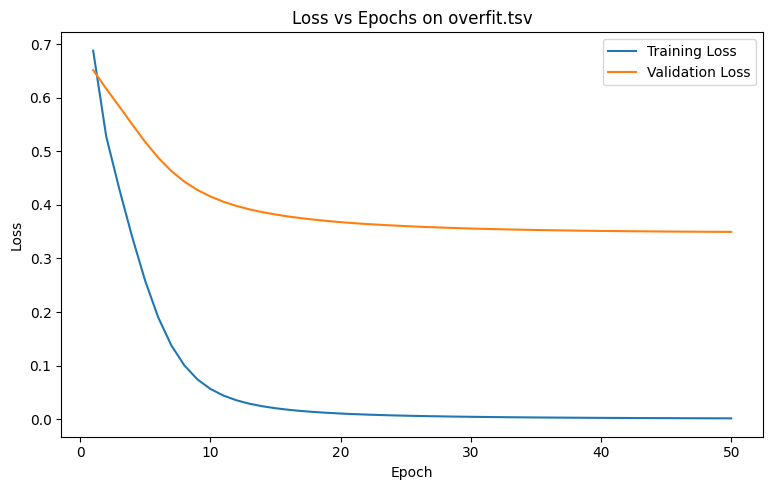

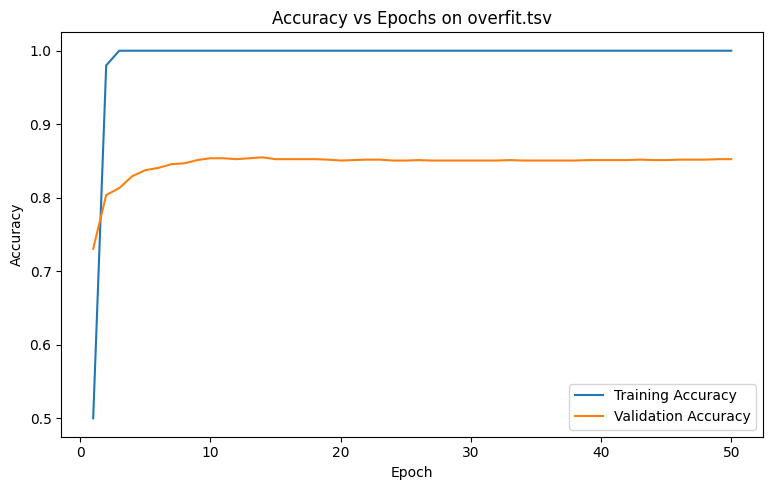

In [60]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_overfit(args_batch_size = 4):
  torch.manual_seed(2)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print ("Using device:", device)

  # Hyperparameters:
  embedding_dim = 100 # We use embedding size = 100
  learning_rate = 0.001
  num_epochs = 50
  batch_size = args_batch_size

  # Initialize:
  model = CNNClassifier(vocab=glove)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  train_loader, validation_loader, test_loader, overfit_loader = create_dataloaders(
      args_batch_size = args_batch_size, device = device
  )

  with tqdm(range(num_epochs), unit="epoch") as epochs_tqdm:
    epochs_tqdm.set_description("Training epochs:")
    for epoch in epochs_tqdm:
      model.train()

      total_loss = 0
      correct = 0
      total = 0

      for inputs, targets in overfit_loader:

        inputs = inputs.transpose(0, 1)

        optimizer.zero_grad()

        # print('inputs.shape', inputs.shape)
        outputs = model.forward(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predicted = (torch.sigmoid(outputs) > 0.5).int()
        correct += (predicted.squeeze(-1) == targets).sum().item()

        total += targets.size(0)

      avg_loss = total_loss / len(overfit_loader)
      accuracy = correct / total

      train_losses.append(avg_loss)
      train_accuracies.append(accuracy)

      # Evaluate on the val set after each epoch:
      model.eval()
      total_val_loss = 0
      correct_val = 0
      total_val = 0

      with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.transpose(0, 1)

            outputs = model.forward(inputs)
            val_loss = criterion(outputs, targets.unsqueeze(1).float())

            total_val_loss += val_loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).int()
            correct_val += (predicted.squeeze(-1) == targets).sum().item()
            total_val += targets.size(0)

      avg_val_loss = total_val_loss / len(validation_loader)
      val_accuracy = correct_val / total_val

      val_losses.append(avg_val_loss)
      val_accuracies.append(val_accuracy)

  # Evaluate on the test set after training is complete:
  model.eval()
  total_test_loss = 0
  correct_test = 0
  total_test = 0

  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs = inputs.transpose(0, 1)
          outputs = model.forward(inputs)
          test_loss = criterion(outputs, targets.unsqueeze(1).float())

          total_test_loss += test_loss.item()
          predicted = (torch.sigmoid(outputs) > 0.5).int()
          correct_test += (predicted.squeeze(-1) == targets).sum().item()
          total_test += targets.size(0)

  avg_test_loss = total_test_loss / len(test_loader)
  test_accuracy = correct_test / total_test

  print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

  # Plot:
  plot_loss_curves(num_epochs, train_losses, val_losses)
  plot_accuracy_curves(num_epochs, train_accuracies, val_accuracies)

  return model


# Run the training loop on the baseline model:
trained_baseline_model = train_overfit(args_batch_size=4)

## Obtaining the Trained CNN Model with Hyperparameter Tuning

In [61]:
def plot_loss_curves(num_epochs, train_losses, val_losses):
  # Plotting
  plt.figure(figsize=(15, 5))

  # Plot training loss and test loss
  plt.subplot(1, 2, 1)
  plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
  plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss vs Epochs using train.tsv")
  plt.legend()

  plt.tight_layout()
  plt.show()

def plot_accuracy_curves(num_epochs, train_accuracies, val_accuracies):
  # Plotting
  plt.figure(figsize=(15, 5))

  # Plot training accuracy and test accuracy
  plt.subplot(1, 2, 2)
  plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
  plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epochs using train.tsv")
  plt.legend()

  plt.tight_layout()
  plt.show()

In [62]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(
    args_batch_size=4, arg_k1=2, arg_n1=10, arg_k2=4, arg_n2=10,
    learning_rate=0.001, num_epochs=50
):
  torch.manual_seed(2)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print ("Using device:", device)

  # Instantiate your model(s) and train them and so on

  # Hyperparameters:
  embedding_dim = 100 # We use embedding size = 100
  # learning_rate = 0.001
  # num_epochs = 50
  batch_size = args_batch_size

  # Initialize the model using different hyperparameters:
  model = CNNClassifier(
      vocab=glove, k1=arg_k1, n1=arg_n1, k2=arg_k2, n2=arg_n2
  )
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  train_dataloader, validation_dataloader, test_loader, overfit_loader = create_dataloaders(
      args_batch_size = args_batch_size, device = device
  )

  with tqdm(range(num_epochs), unit="epoch") as epochs_tqdm:
    epochs_tqdm.set_description("Training epochs:")
    for epoch in epochs_tqdm:
      model.train()

      total_loss = 0
      correct = 0
      total = 0

      for inputs, targets in train_dataloader:

        inputs = inputs.transpose(0, 1)

        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predicted = (torch.sigmoid(outputs) > 0.5).int()
        correct += (predicted.squeeze(-1) == targets).sum().item()

        total += targets.size(0)

      avg_loss = total_loss / len(train_dataloader)
      accuracy = correct / total

      train_losses.append(avg_loss)
      train_accuracies.append(accuracy)

      # Evaluate on the val set after each epoch:
      model.eval()
      total_val_loss = 0
      correct_val = 0
      total_val = 0

      with torch.no_grad():
        for inputs, targets in validation_dataloader:
            inputs = inputs.transpose(0, 1)

            outputs = model.forward(inputs)
            val_loss = criterion(outputs, targets.unsqueeze(1).float())

            total_val_loss += val_loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).int()
            correct_val += (predicted.squeeze(-1) == targets).sum().item()
            total_val += targets.size(0)

      avg_val_loss = total_val_loss / len(validation_dataloader)
      val_accuracy = correct_val / total_val

      val_losses.append(avg_val_loss)
      val_accuracies.append(val_accuracy)



  # Evaluate on the test set after training is complete:
  model.eval()
  total_test_loss = 0
  correct_test = 0
  total_test = 0

  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs = inputs.transpose(0, 1)
          outputs = model.forward(inputs)
          test_loss = criterion(outputs, targets.unsqueeze(1).float())

          total_test_loss += test_loss.item()
          predicted = (torch.sigmoid(outputs) > 0.5).int()
          correct_test += (predicted.squeeze(-1) == targets).sum().item()
          total_test += targets.size(0)

  avg_test_loss = total_test_loss / len(test_loader)
  test_accuracy = correct_test / total_test

  print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

  # Plot:
  # plot_loss_curves(num_epochs, train_losses, val_losses)
  # plot_accuracy_curves(num_epochs, train_accuracies, val_accuracies)

  return model, test_accuracy, train_losses, train_accuracies, val_losses, val_accuracies

Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 4, 'learning_rate': 0.001, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:22<00:00,  2.85s/epoch]


Test Loss: 0.6019, Test Accuracy: 0.9015
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 4, 'learning_rate': 0.001, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:28<00:00,  2.97s/epoch]


Test Loss: 0.5617, Test Accuracy: 0.9050
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 4, 'learning_rate': 0.001, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:27<00:00,  2.95s/epoch]


Test Loss: 0.5483, Test Accuracy: 0.9075
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 4, 'learning_rate': 0.001, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:32<00:00,  3.05s/epoch]


Test Loss: 0.6014, Test Accuracy: 0.9080
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 4, 'learning_rate': 0.01, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:22<00:00,  2.85s/epoch]


Test Loss: 1.4305, Test Accuracy: 0.8905
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 4, 'learning_rate': 0.01, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:28<00:00,  2.98s/epoch]


Test Loss: 1.8944, Test Accuracy: 0.8820
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 4, 'learning_rate': 0.01, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:27<00:00,  2.95s/epoch]


Test Loss: 1.8945, Test Accuracy: 0.8880
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 4, 'learning_rate': 0.01, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:31<00:00,  3.02s/epoch]


Test Loss: 2.1720, Test Accuracy: 0.8875
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 8, 'learning_rate': 0.001, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:08<00:00,  3.77s/epoch]


Test Loss: 0.6948, Test Accuracy: 0.8930
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 8, 'learning_rate': 0.001, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:18<00:00,  3.97s/epoch]


Test Loss: 0.6953, Test Accuracy: 0.9020
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 8, 'learning_rate': 0.001, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:10<00:00,  3.80s/epoch]


Test Loss: 0.6288, Test Accuracy: 0.9045
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 8, 'learning_rate': 0.001, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:21<00:00,  4.03s/epoch]


Test Loss: 0.6835, Test Accuracy: 0.9125
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 8, 'learning_rate': 0.01, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:07<00:00,  3.76s/epoch]


Test Loss: 1.7639, Test Accuracy: 0.8675
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 8, 'learning_rate': 0.01, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:14<00:00,  3.89s/epoch]


Test Loss: 1.7524, Test Accuracy: 0.8755
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 8, 'learning_rate': 0.01, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:09<00:00,  3.80s/epoch]


Test Loss: 2.0690, Test Accuracy: 0.8810
Testing parameters: {'batch_size': 16, 'k1': 2, 'k2': 8, 'learning_rate': 0.01, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:20<00:00,  4.01s/epoch]


Test Loss: 1.8083, Test Accuracy: 0.8895
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 4, 'learning_rate': 0.001, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:47<00:00,  3.34s/epoch]


Test Loss: 0.5931, Test Accuracy: 0.8900
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 4, 'learning_rate': 0.001, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:55<00:00,  3.50s/epoch]


Test Loss: 0.5692, Test Accuracy: 0.9135
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 4, 'learning_rate': 0.001, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:55<00:00,  3.50s/epoch]


Test Loss: 0.5692, Test Accuracy: 0.9135
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 4, 'learning_rate': 0.001, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:00<00:00,  3.61s/epoch]


Test Loss: 0.5934, Test Accuracy: 0.9165
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 4, 'learning_rate': 0.01, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:06<00:00,  3.73s/epoch]


Test Loss: 1.8696, Test Accuracy: 0.8825
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 4, 'learning_rate': 0.01, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:10<00:00,  3.82s/epoch]


Test Loss: 1.7312, Test Accuracy: 0.8915
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 4, 'learning_rate': 0.01, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:57<00:00,  3.55s/epoch]


Test Loss: 1.7312, Test Accuracy: 0.8915
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 4, 'learning_rate': 0.01, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:58<00:00,  3.57s/epoch]


Test Loss: 1.9646, Test Accuracy: 0.8825
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 8, 'learning_rate': 0.001, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:31<00:00,  4.23s/epoch]


Test Loss: 0.6601, Test Accuracy: 0.9040
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 8, 'learning_rate': 0.001, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:40<00:00,  4.40s/epoch]


Test Loss: 0.6580, Test Accuracy: 0.9085
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 8, 'learning_rate': 0.001, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:37<00:00,  4.34s/epoch]


Test Loss: 0.6875, Test Accuracy: 0.9045
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 8, 'learning_rate': 0.001, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:44<00:00,  4.49s/epoch]


Test Loss: 0.6715, Test Accuracy: 0.9055
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 8, 'learning_rate': 0.01, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:29<00:00,  4.19s/epoch]


Test Loss: 1.8448, Test Accuracy: 0.8660
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 8, 'learning_rate': 0.01, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:38<00:00,  4.37s/epoch]


Test Loss: 1.8634, Test Accuracy: 0.8725
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 8, 'learning_rate': 0.01, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:35<00:00,  4.32s/epoch]


Test Loss: 1.5788, Test Accuracy: 0.8800
Testing parameters: {'batch_size': 16, 'k1': 4, 'k2': 8, 'learning_rate': 0.01, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:45<00:00,  4.50s/epoch]


Test Loss: 1.7041, Test Accuracy: 0.8990
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 4, 'learning_rate': 0.001, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:09<00:00,  2.60s/epoch]


Test Loss: 0.5759, Test Accuracy: 0.8895
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 4, 'learning_rate': 0.001, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:17<00:00,  2.74s/epoch]


Test Loss: 0.4456, Test Accuracy: 0.9080
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 4, 'learning_rate': 0.001, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:14<00:00,  2.69s/epoch]


Test Loss: 0.4356, Test Accuracy: 0.9120
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 4, 'learning_rate': 0.001, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:20<00:00,  2.81s/epoch]


Test Loss: 0.4123, Test Accuracy: 0.9115
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 4, 'learning_rate': 0.01, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:11<00:00,  2.64s/epoch]


Test Loss: 0.8171, Test Accuracy: 0.9015
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 4, 'learning_rate': 0.01, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:16<00:00,  2.73s/epoch]


Test Loss: 0.9391, Test Accuracy: 0.8920
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 4, 'learning_rate': 0.01, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:13<00:00,  2.67s/epoch]


Test Loss: 0.8549, Test Accuracy: 0.8985
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 4, 'learning_rate': 0.01, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:21<00:00,  2.82s/epoch]


Test Loss: 0.8476, Test Accuracy: 0.9045
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 8, 'learning_rate': 0.001, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:00<00:00,  3.61s/epoch]


Test Loss: 0.4995, Test Accuracy: 0.8995
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 8, 'learning_rate': 0.001, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:10<00:00,  3.81s/epoch]


Test Loss: 0.4576, Test Accuracy: 0.9075
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 8, 'learning_rate': 0.001, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:02<00:00,  3.66s/epoch]


Test Loss: 0.4541, Test Accuracy: 0.9055
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 8, 'learning_rate': 0.001, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:13<00:00,  3.88s/epoch]


Test Loss: 0.4720, Test Accuracy: 0.9060
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 8, 'learning_rate': 0.01, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:58<00:00,  3.57s/epoch]


Test Loss: 1.2375, Test Accuracy: 0.8770
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 8, 'learning_rate': 0.01, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:09<00:00,  3.79s/epoch]


Test Loss: 1.2247, Test Accuracy: 0.8790
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 8, 'learning_rate': 0.01, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:00<00:00,  3.61s/epoch]


Test Loss: 0.9161, Test Accuracy: 0.9035
Testing parameters: {'batch_size': 32, 'k1': 2, 'k2': 8, 'learning_rate': 0.01, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:12<00:00,  3.85s/epoch]


Test Loss: 0.9794, Test Accuracy: 0.8920
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 4, 'learning_rate': 0.001, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:35<00:00,  3.10s/epoch]


Test Loss: 0.5019, Test Accuracy: 0.8965
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 4, 'learning_rate': 0.001, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:42<00:00,  3.25s/epoch]


Test Loss: 0.4294, Test Accuracy: 0.9105
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 4, 'learning_rate': 0.001, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:43<00:00,  3.27s/epoch]


Test Loss: 0.4294, Test Accuracy: 0.9105
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 4, 'learning_rate': 0.001, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:50<00:00,  3.42s/epoch]


Test Loss: 0.4364, Test Accuracy: 0.9175
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 4, 'learning_rate': 0.01, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:34<00:00,  3.09s/epoch]


Test Loss: 0.9506, Test Accuracy: 0.8875
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 4, 'learning_rate': 0.01, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:42<00:00,  3.25s/epoch]


Test Loss: 0.9571, Test Accuracy: 0.9025
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 4, 'learning_rate': 0.01, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:43<00:00,  3.27s/epoch]


Test Loss: 0.9571, Test Accuracy: 0.9025
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 4, 'learning_rate': 0.01, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:47<00:00,  3.36s/epoch]


Test Loss: 0.9482, Test Accuracy: 0.9050
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 8, 'learning_rate': 0.001, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:23<00:00,  4.08s/epoch]


Test Loss: 0.4761, Test Accuracy: 0.9055
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 8, 'learning_rate': 0.001, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:33<00:00,  4.28s/epoch]


Test Loss: 0.4870, Test Accuracy: 0.9045
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 8, 'learning_rate': 0.001, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:30<00:00,  4.22s/epoch]


Test Loss: 0.4705, Test Accuracy: 0.9020
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 8, 'learning_rate': 0.001, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:46<00:00,  4.53s/epoch]


Test Loss: 0.4701, Test Accuracy: 0.9030
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 8, 'learning_rate': 0.01, 'n1': 10, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:25<00:00,  4.12s/epoch]


Test Loss: 1.3580, Test Accuracy: 0.8700
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 8, 'learning_rate': 0.01, 'n1': 10, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:36<00:00,  4.33s/epoch]


Test Loss: 1.1052, Test Accuracy: 0.8880
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 8, 'learning_rate': 0.01, 'n1': 20, 'n2': 10}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:33<00:00,  4.27s/epoch]


Test Loss: 0.9089, Test Accuracy: 0.8965
Testing parameters: {'batch_size': 32, 'k1': 4, 'k2': 8, 'learning_rate': 0.01, 'n1': 20, 'n2': 20}
Using device: cpu


Training epochs:: 100%|██████████| 50/50 [03:49<00:00,  4.59s/epoch]


Test Loss: 0.9974, Test Accuracy: 0.8885
Best parameters: {'batch_size': 32, 'k1': 4, 'k2': 4, 'learning_rate': 0.001, 'n1': 20, 'n2': 20}
Best test accuracy: 0.9175


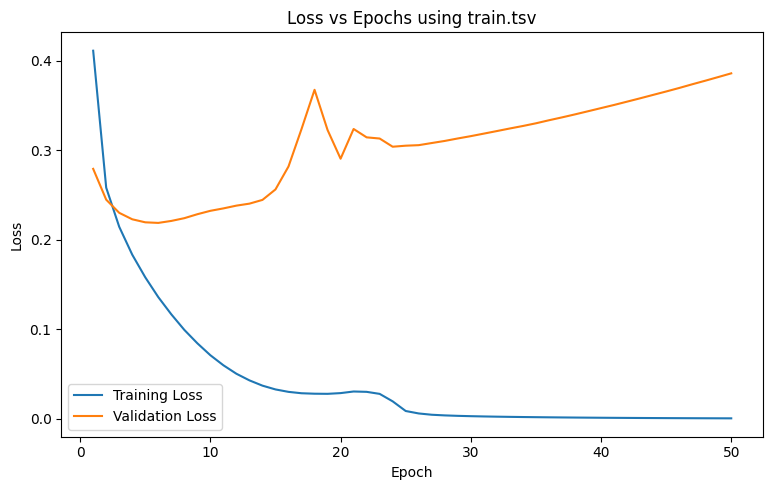

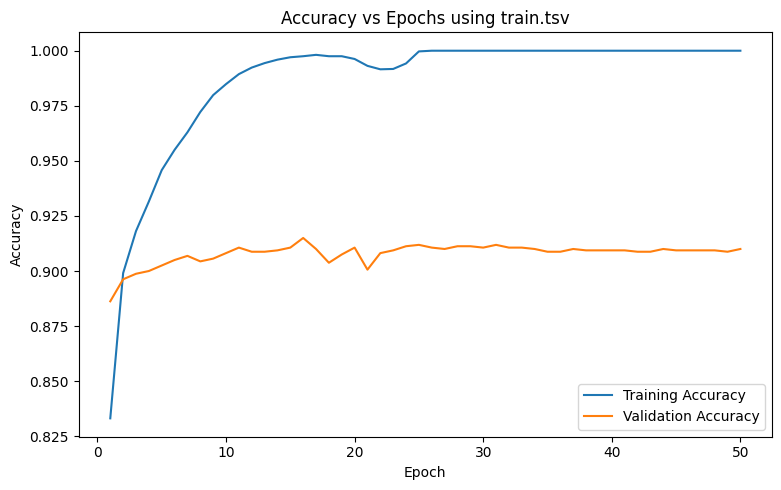

In [65]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'k1': [2, 4],
    'n1': [10, 20],
    'k2': [4, 8],
    'n2': [10, 20],
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.01]
}

best_accuracy = 0
best_params = {}
best_model = None
best_train_losses = []
best_train_accuracies = []
best_val_losses = []
best_val_accuracies = []

# Loop through the parameters:
for params in ParameterGrid(param_grid):
  print(f"Testing parameters: {params}")
  trained_model, test_accuracy, train_losses, train_accuracies, val_losses, val_accuracies = train(
      args_batch_size=params['batch_size'],
      arg_k1=params['k1'], arg_n1=params['n1'],
      arg_k2=params['k2'], arg_n2=params['n2'],
      learning_rate=params['learning_rate']
  )
  if test_accuracy > best_accuracy:
    best_accuracy = test_accuracy
    best_params = params
    best_model = trained_model
    best_train_losses = train_losses
    best_train_accuracies = train_accuracies
    best_val_losses = val_losses
    best_val_accuracies = val_accuracies

print(f"Best parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy}")

# Plot:
plot_loss_curves(50, best_train_losses, best_val_losses)
plot_accuracy_curves(50, best_train_accuracies, best_val_accuracies)


We re-define the CNN classifier but with `freeze=False`:

In [68]:
class CNNClassifier(nn.Module):
  def __init__(self, vocab, k1=2, k2=4, n1=50, n2=50):
    super(CNNClassifier, self).__init__()

    self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=False)

    # Convolutional layers:
    embedding_dim = vocab.vectors.shape[1]
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=n1, kernel_size=(k1, embedding_dim), bias=False)
    self.conv2 = nn.Conv2d(in_channels=1, out_channels=n2, kernel_size=(k2, embedding_dim), bias=False)

    # Fully-connected layer:
    # Input size: n1 + n2
    self.fc = nn.Linear(n1 + n2, 1)

  def forward(self, x):
    # Expand word indices to word embeddings:
    embeddings = self.embedding(x)
    embeddings = embeddings.unsqueeze(1)

    # Use ReLU:
    conv1_out = nn.functional.relu(self.conv1(embeddings))
    conv2_out = nn.functional.relu(self.conv2(embeddings))

    pool1_out = nn.functional.max_pool2d(conv1_out, kernel_size=(conv1_out.size(2), 1)).squeeze(2)
    pool2_out = nn.functional.max_pool2d(conv2_out, kernel_size=(conv2_out.size(2), 1)).squeeze(2)

    combined = torch.cat((pool1_out, pool2_out), dim=1)
    combined = combined.squeeze(2)

    output = self.fc(combined)

    return output

In [69]:
trained_model, test_accuracy, train_losses, train_accuracies, val_losses, val_accuracies = train(
    args_batch_size=32,
    arg_k1=4, arg_n1=20,
    arg_k2=4, arg_n2=20,
    learning_rate=0.001
)

Using device: cpu


Training epochs:: 100%|██████████| 50/50 [02:53<00:00,  3.47s/epoch]


Test Loss: 0.4331, Test Accuracy: 0.9165


Kernel values:

In [74]:
conv1_kernels = trained_model.conv1.weight.data
conv2_kernels = trained_model.conv2.weight.data
print(conv1_kernels[0][0][0].shape)

# Print out the N-most (where N is a parameter) similar words using cosine similarity
def print_closest_cosine_words(vec, n=5):
    # Unsqueeze to 2D tensors in order to use `torch.cosine_similarity()`:
    cos_similarities = torch.cosine_similarity(vec.unsqueeze(0), glove.vectors.unsqueeze(1), dim=2) # `dim=2` is important
    # print(cos_similarities[0:5])

    # Use enumerate() to create pairs of an index and a cosine similarity value:
    lst = sorted(enumerate(cos_similarities), key=lambda x: x[1], reverse=True) # descending order
    for idx, difference in lst[1:n+1]: # takes the top n words other than that word itself
        print(glove.itos[idx], "\t%5.2f" % difference)

print_closest_cosine_words(conv1_kernels[0][0][0], n=5)

torch.Size([100])
redirection 	 0.48
tidbit 	 0.48
condiment 	 0.44
copout 	 0.44
deflects 	 0.43


In [70]:
torch.save(trained_model.state_dict(), 'cnn.pt')